In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/Project/

import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/Project/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Project


In [0]:
import datetime
import numpy as np
import cv2, dlib
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch.utils.data as data_utils
from imutils import face_utils

Using TensorFlow backend.


Reading eye dataset to pandas dataframe

In [0]:
eye_df = pd.read_csv('dataset/eye_dataset.csv')
eye_df.head()

,state,image
0,open,"178, 179, 181, 180, 175, 171, 170, 168, 162, 1..."
1,open,"67, 66, 65, 64, 62, 62, 61, 61, 60, 61, 61, 58..."
2,open,"80, 84, 90, 94, 97, 100, 103, 107, 108, 112, 1..."
3,open,"83, 81, 80, 81, 82, 81, 79, 78, 79, 80, 81, 79..."
4,close,"121, 126, 131, 136, 140, 144, 146, 146, 151, 1..."


Sample image array

In [0]:
eye_df['image'][0]

Reshaping all the images to the size of 26x34x1 arrays

In [0]:
reshaped_images = []
for x in range(2874):
  eye = (np.array([int(s) for s in eye_df['image'][x].split(',')])).reshape(26, 34, 1)
  eye_df['image'][x] = eye
  reshaped_images.append(eye)

Few sample images from the dataset

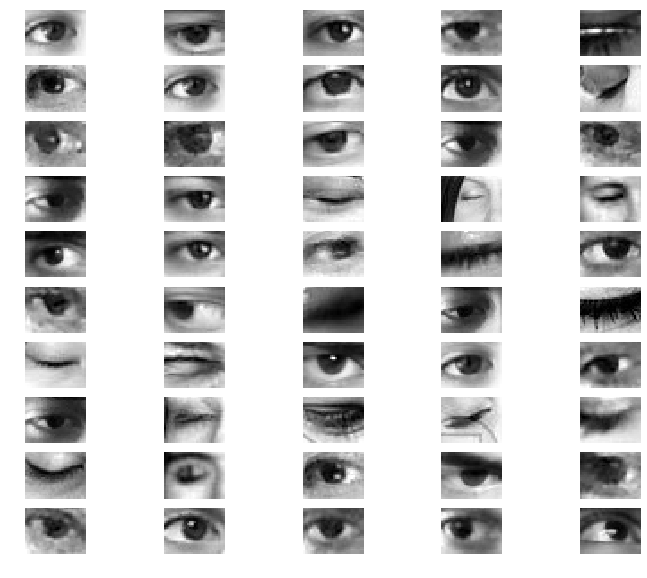

In [0]:
plt.figure(figsize=(12, 10), facecolor='white')
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(eye_df['image'][i].reshape((26, 34)), cmap='gray')

Stack up all the image arrays

In [0]:
images_stack = np.stack(reshaped_images, axis=0)
images_stack.shape

(2874, 26, 34, 1)

In [0]:
images_stack[1].shape

In [0]:
eye_df['image'][0].shape

Convert labels to binary

In [0]:
eye_df.state = pd.Categorical(eye_df.state)
eye_df['state'] = eye_df.state.cat.codes

In [0]:
eye_df.head()

In [0]:
x = images_stack
y = eye_df['state']
print('Total number of samples ',len(y))

Total number of samples  2874


In [0]:
#train test splits 
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, shuffle=True)

#checking their shapes
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2299, 26, 34, 1) (2299,) (575, 26, 34, 1) (575,)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**Neural Network**

In [0]:
model = Sequential()

model.add(Conv2D(64, input_shape=(26, 34, 1), kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 34, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 17, 256)       147712    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 8, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               6291968   
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
__________

Split data for training and validating

In [0]:
train_data = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
valid_data = ImageDataGenerator(rescale=1./255)


train_generator = train_data.flow(x=x_train, y=y_train, batch_size=32, shuffle=False)
valid_generator = valid_data.flow(x=x_val, y=y_val, batch_size=32, shuffle=False)

In [0]:
callback = [ModelCheckpoint('models.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1), EarlyStopping(monitor='val_loss', patience=8)]

**Train the developed model**

In [0]:
model.fit_generator(train_generator, steps_per_epoch=70, validation_steps=18, epochs=50, validation_data=valid_generator, callbacks=callback)

Epoch 1/50
70/70 [==============================] - 3s 39ms/step - loss: 0.5438 - acc: 0.7031 - val_loss: 0.3336 - val_acc: 0.8591

Epoch 00001: val_acc improved from -inf to 0.85913, saving model to models.h5
Epoch 2/50
70/70 [==============================] - 2s 23ms/step - loss: 0.3232 - acc: 0.8627 - val_loss: 0.1590 - val_acc: 0.9443

Epoch 00002: val_acc improved from 0.85913 to 0.94435, saving model to models.h5
Epoch 3/50
70/70 [==============================] - 2s 23ms/step - loss: 0.2525 - acc: 0.9033 - val_loss: 0.1401 - val_acc: 0.9391

Epoch 00003: val_acc did not improve from 0.94435
Epoch 4/50
70/70 [==============================] - 2s 22ms/step - loss: 0.1969 - acc: 0.9248 - val_loss: 0.1266 - val_acc: 0.9583

Epoch 00004: val_acc improved from 0.94435 to 0.95826, saving model to models.h5
Epoch 5/50
70/70 [==============================] - 2s 22ms/step - loss: 0.1785 - acc: 0.9401 - val_loss: 0.1285 - val_acc: 0.9530

Epoch 00005: val_acc did not improve from 0.95826


In [0]:
#loading saved model
model = load_model('models.h5')

**Classification Results**

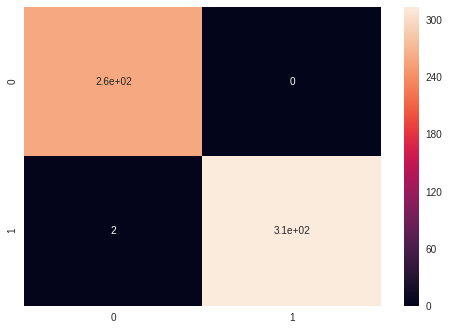

In [0]:
y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

In [0]:
print(classification_report(y_val, y_pred_logical))
print ('Test accuracy: %s' % (accuracy_score(y_val, y_pred_logical)*100))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       260
           1       1.00      0.99      1.00       315

   micro avg       1.00      1.00      1.00       575
   macro avg       1.00      1.00      1.00       575
weighted avg       1.00      1.00      1.00       575

Test accuracy: 99.65217391304347


In [0]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
image_shape = (34, 26)
image_matrix = (1, image_shape[1], image_shape[0], 1)

In [0]:
def extract_eye(image, eye_points):

  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * image_shape[1] / image_shape[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rectangle = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_image = image[eye_rectangle[1]:eye_rectangle[3], eye_rectangle[0]:eye_rectangle[2]]

  return eye_image, eye_rectangle

**Open the webcame and run the simulator and execute classification**

In [0]:
cap = cv2.VideoCapture(0)

while cap.isOpened():

  ret, image_frame = cap.read()

  if not ret:
    break

  image = cv2.resize(image_frame, dsize=(0, 0), fx=0.5, fy=0.5)

  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = detector(image_gray)

  for face in faces:

    shapes = predictor(image_gray, face)
    shapes = face_utils.shape_to_np(shapes)

    l_eye_image, l_eye_rectangle = extract_eye(image_gray, eye_points = shapes[36:42])
    r_eye_image, r_eye_rectangle = extract_eye(image_gray, eye_points = shapes[42:48])

    l_eye_image = cv2.resize(l_eye_image, dsize = image_shape)
    r_eye_image = cv2.resize(r_eye_image, dsize = image_shape)
    r_eye_image = cv2.flip(r_eye_image, flipCode=1)

    cv2.imshow('l', l_eye_image)
    cv2.imshow('r', r_eye_image)

    l_eye_input = l_eye_image.copy().reshape(image_matrix).astype(np.float32) / 255.
    r_eye_input = r_eye_image.copy().reshape(image_matrix).astype(np.float32) / 255.

    l_eye_prediction = model.predict(l_eye_input)
    r_eye_prediction = model.predict(r_eye_input)


    l_color = (0, 255, 0) if l_eye_prediction > 0.01 else (0, 0, 255)
    r_color = (0, 255, 0) if r_eye_prediction > 0.01 else (0, 0, 255)


    cv2.rectangle(image, tuple(l_eye_rectangle[0:2]), tuple(l_eye_rectangle[2:4]), l_color, 2)
    cv2.rectangle(image, tuple(r_eye_rectangle[0:2]), tuple(r_eye_rectangle[2:4]), r_color, 2)

  cv2.imshow('result', image)
  if cv2.waitKey(1) == ord('q'):
    break

